# Modelo Binomial para calls - Derivativos

(igual o Bruno fez na aula)

# Parte 1: entradas de valores

### Importar Pacotes

In [29]:
import pandas as pd
import numpy as np
import yfinance as yf

### Série Histórica do Ativo

In [30]:
inicio = "2019-12-31" # trocar
fim = pd.to_datetime("today") # data atual (retorna o dia de hoje, mas pode ser uma data qualquer)
ativo = "BBDC4.SA"

### Características da Opção

In [53]:
nome = "BBDCB234" # alterar
r = 0.0915 # taxa livre de risco - alterar
S = dados.iloc[len(dados)-1]["Adj Close"] # preço spot
X = 23.17 # strike da opção - alterar
dt = 14 # dias úteis até o vencimento - alterar
C0 = 0.44 # preço atual da opção - alterar

# Parte 2: modelagem

### Importa dados

In [49]:
dados = yf.download(start = inicio, end = fim, tickers = ativo)
dados["retorno"] = dados["Adj Close"].pct_change()
dados.dropna(inplace = True)

[*********************100%***********************]  1 of 1 completed


### Calcula média de alta, baixa e proporção diária de cada uma

In [50]:
df = dados[["Adj Close", "retorno"]]
pd.options.mode.chained_assignment = None  # default='warn'

df["up"] = np.where(df["retorno"] >= 0, df["retorno"], 0)
df["q"] = np.where(df["retorno"] >= 0, 1, 0)
df["down"] = np.where(df["retorno"] < 0, df["retorno"], 0)
df["1-q"] = np.where(df["retorno"] >= 0, 0, 1)

q = sum(df["q"])/len(df["q"])
u = df[df["up"] != 0].mean()["up"]
d = df[df["down"] != 0].mean()["down"]

### Probabilidades de cada um dos cenários finais possíveis

Os cenários do meio podem ser alcançados de n formas diferentes, sendo n equivalente ao seu valor no triângulo de Pascal (onde cada número é a soma dos 2 anteriores a ele, vide imagem)

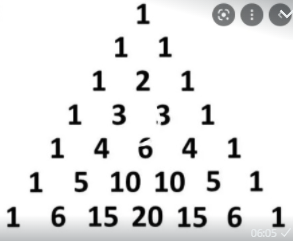

In [61]:
mults

[0.7396461763139444,
 -0.26572460682247007,
 -1.3128893001177644,
 -2.4031443864694286,
 -3.537822053245632,
 -4.718291113650815,
 -5.9459579509106675,
 -7.222267485825878,
 -8.548704168257,
 -9.92679299311603,
 -11.35810054145386,
 -12.844236047246678,
 -14.386852490498507,
 -15.987647717291697,
 -17.648365587431993,
 -19.370797150350047]

In [62]:
mults, probs = [], [] # valores dos nós finais da árvore, com suas probabilidades 
for i in range(dt+1):
    
    mult = ((1+u)**i)*((1+d)**(dt-i))
    mults.append(mult)
    
    prob = ((q)**i) * ((1-q) ** (dt-i))
    probs.append(prob)

# retorna as linhas do triangulo de pascal, só a última interessa
def tri_pascal(n): 
    linhas = [[1], [1,1]]
    for i in range(n-1):
        linha_ant = linhas[-1]

        linha_nova = [1]
        for j in range(i+1):
            num = linha_ant[j] + linha_ant[j+1]
            linha_nova.append(num)
        linha_nova.append(1)   

        linhas.append(linha_nova)
    return linhas

# multiplica a prob pelo valor da sua posição no triângulo de pascal
probabilidades = [probs[i] * tri_pascal(dt)[-1][i] for i in range(len(probs))] 

### Valor esperado para o preço da call 

In [64]:
# Calculando os preços possíveis
precos = [i*S for i in mults]

# Preço final - strike
resultado = [X-i for i in precos]

# Preço da call é igual ao resultado se ele for positivo
precos_calls = [i if i > 0 else 0 for i in resultado]

# média ponderada do preço esperado da call 
C = 0
for i in range(len(precos_calls)):
    C += precos_calls[i]*probabilidades[i]

# descontando o preço pela taxa livre de risco
C = C * np.exp(-r*dt/21)

### Resultado

In [65]:
res = {"Variável" : ["Ticker da Opção",
                     "Preço Spot do Ativo",
                     "Strike da Opção",
                     "Dias-úteis até o vencimento",
                     "Taxa Livre de Risco",
                     "Preço Alvo da Opção",
                     "Preço Atual da Opção",
                     "Resultado Alvo da Operação"],
       "Valor" : [nome,
                  "R$ {:2.2f}".format(S),
                  "R$ {:2.2f}".format(X),
                  str(dt),
                  "{:.2%}".format(r),
                  "R$ {:5.2f}".format(C),
                  "R$ {:5.2f}".format(C0),
                  "{:.2%}".format((C/C0)-1)]}

pd.DataFrame(res)

,Variável,Valor
0,Ticker da Opção,BBDCB234
1,Preço Spot do Ativo,R$ 22.55
2,Strike da Opção,R$ 23.17
3,Dias-úteis até o vencimento,14
4,Taxa Livre de Risco,9.15%
5,Preço Alvo da Opção,R$ 0.98
6,Preço Atual da Opção,R$ 0.44
7,Resultado Alvo da Operação,123.71%
